In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objs as go
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

/Users/marcelocardoso/miniconda3/envs/.venv_conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('df.csv')
df.set_index(df.Data, inplace=True)
df.drop('Data', inplace=True, axis=1)

In [3]:
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%,ds,y
Data,,,,,,,,
2003-01-02,11.603,11.291,11.603,11.291,195130000,2.97,2003-01-02,11.603
2003-01-03,11.600,11.632,11.798,11.600,197050000,-0.02,2003-01-03,11.600
2003-01-06,12.020,11.636,12.032,11.633,398400000,3.62,2003-01-06,12.020
2003-01-07,11.876,12.010,12.018,11.842,387980000,-1.19,2003-01-07,11.876
2003-01-08,11.786,11.875,11.928,11.757,217190000,-0.76,2003-01-08,11.786
...,...,...,...,...,...,...,...,...
2023-03-03,103.866,103.326,104.440,103.323,13100000,0.52,2023-03-03,103.866
2023-03-06,104.700,103.865,105.171,103.170,14280000,0.80,2023-03-06,104.700
2023-03-07,104.228,104.700,105.179,103.480,12580000,-0.45,2023-03-07,104.228


In [4]:
def mape_error(y_true, y_pred):
    n = len(y_true)
    mape = (np.abs((y_true - y_pred) / y_true).sum() / n)
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2%}")
    return mape

def wmape_error(y_true, y_pred):
    wmape = np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
    print(f"WMAPE (Weighted Mean Absolute Percentage Error): {wmape:.2%}")
    return wmape

def smape_error(y_true, y_pred):
    smape = (np.abs(y_pred - y_true) * 2 / (np.abs(y_pred) + np.abs(y_true))).mean()
    print(f"SMAPE (Symmetric Mean Absolute Percentage Error): {smape:.2%}")
    return smape

In [5]:
train = df.loc[df.ds < '2022-12-30'].copy()
test = df.loc[df.ds >= '2022-12-30'].copy()
train.loc[:, 'unique_id'] = 'Fechamento'
train['ds'] = train.index
test.loc[:, 'unique_id'] = 'Fechamento'
test['ds'] = test.index
train.drop(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True, axis=1)
test.drop(['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], inplace=True, axis=1)
h = test.index.nunique()
print(train.shape)
print(test.shape)
print(h)

(4952, 3)
(47, 3)
47


In [6]:
m = Prophet()
m.add_seasonality(name='weekly', period=5, fourier_order=5)
m.fit(train)
future = m.make_future_dataframe(periods=50,freq='B')

20:24:11 - cmdstanpy - INFO - Chain [1] start processing
20:24:16 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
test.shape

(47, 3)

In [8]:
train.shape

(4952, 3)

In [9]:
train

,ds,y,unique_id
Data,,,
2003-01-02,2003-01-02,11.603,Fechamento
2003-01-03,2003-01-03,11.600,Fechamento
2003-01-06,2003-01-06,12.020,Fechamento
2003-01-07,2003-01-07,11.876,Fechamento
2003-01-08,2003-01-08,11.786,Fechamento
...,...,...,...
2022-12-23,2022-12-23,109.698,Fechamento
2022-12-26,2022-12-26,108.738,Fechamento
2022-12-27,2022-12-27,108.578,Fechamento


In [10]:
future.tail(51)

,ds
4951,2022-12-29
4952,2022-12-30
4953,2023-01-02
4954,2023-01-03
4955,2023-01-04
4956,2023-01-05
4957,2023-01-06
4958,2023-01-09
4959,2023-01-10
4960,2023-01-11


In [11]:
#Deixando future com mesma datas de test
future=future.drop(index=[4952,4988,4989])

In [12]:
future.shape

(4999, 1)

In [13]:
test

,ds,y,unique_id
Data,,,
2023-01-02,2023-01-02,106.376,Fechamento
2023-01-03,2023-01-03,104.166,Fechamento
2023-01-04,2023-01-04,105.334,Fechamento
2023-01-05,2023-01-05,107.641,Fechamento
2023-01-06,2023-01-06,108.964,Fechamento
2023-01-09,2023-01-09,109.130,Fechamento
2023-01-10,2023-01-10,110.817,Fechamento
2023-01-11,2023-01-11,112.517,Fechamento
2023-01-12,2023-01-12,111.850,Fechamento


In [14]:
prophet_forecast = m.predict(future)
prophet_future=prophet_forecast.tail(47)
prophet_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
4952,2023-01-02,117.940558,110.449453,125.774403
4953,2023-01-03,118.061634,110.744465,126.225457
4954,2023-01-04,118.150350,110.596309,125.848658
4955,2023-01-05,118.312121,110.639804,125.901471
4956,2023-01-06,118.496166,110.781876,126.475488
4957,2023-01-09,118.643009,110.724499,125.728242
4958,2023-01-10,118.767617,111.130775,126.424226
4959,2023-01-11,118.909856,111.408913,126.494970
4960,2023-01-12,118.858829,111.437612,126.977737
4961,2023-01-13,118.905767,110.901493,126.783494


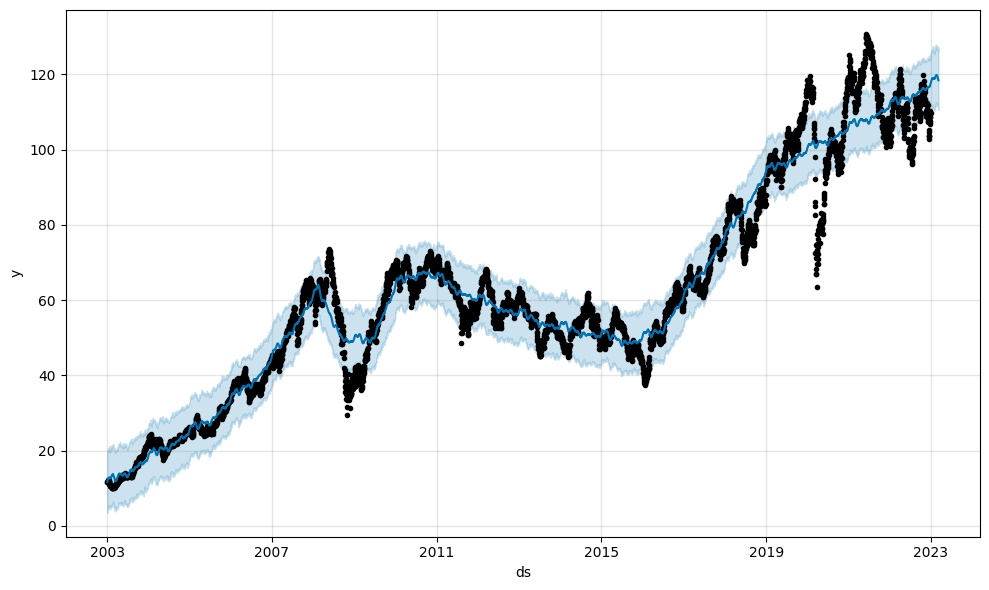

In [15]:
fig = m.plot(prophet_forecast)

In [16]:
plot_components_plotly(m, prophet_forecast)

In [17]:
model_names = ['Prophet']
mape_errors = [mape_error(test['y'].values, prophet_future['yhat'].values)]
wmape_errors = [wmape_error(test['y'].values, prophet_future['yhat'].values)]
smape_errors = [smape_error(test['y'].values, prophet_future['yhat'].values)]
df_error = pd.DataFrame({'model': model_names, 'mape': mape_errors, 'wmape': wmape_errors, 'smape': smape_errors})
df_error.to_csv('Data/ErrorsProphet.csv', index=False)

MAPE (Mean Absolute Percentage Error): 9.35%
WMAPE (Weighted Mean Absolute Percentage Error): 9.27%
SMAPE (Symmetric Mean Absolute Percentage Error): 8.89%
